In [30]:
import kagglehub

#Common Helpers
from sklearn.preprocessing import RobustScaler
from sklearn import metrics
import numpy as np

#Visualization
import matplotlib as mpl
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Download dataset
path = kagglehub.dataset_download("rajeevw/ufcdata")

print("Path to dataset files:", path)
data_df = pd.read_csv(path + '/data.csv')
data_df.head()

Path to dataset files: /root/.cache/kagglehub/datasets/rajeevw/ufcdata/versions/2


,R_fighter,B_fighter,Referee,date,location,Winner,title_bout,weight_class,B_avg_KD,B_avg_opp_KD,...,R_win_by_Decision_Unanimous,R_win_by_KO/TKO,R_win_by_Submission,R_win_by_TKO_Doctor_Stoppage,R_Stance,R_Height_cms,R_Reach_cms,R_Weight_lbs,B_age,R_age
0,Adrian Yanez,Gustavo Lopez,Chris Tognoni,2021-03-20,"Las Vegas, Nevada, USA",Red,False,Bantamweight,0.000,0.0,...,0,1,0,0,Orthodox,170.18,177.80,135.0,31.0,27.0
1,Trevin Giles,Roman Dolidze,Herb Dean,2021-03-20,"Las Vegas, Nevada, USA",Red,False,Middleweight,0.500,0.0,...,0,3,0,0,Orthodox,182.88,187.96,185.0,32.0,28.0
2,Tai Tuivasa,Harry Hunsucker,Herb Dean,2021-03-20,"Las Vegas, Nevada, USA",Red,False,Heavyweight,NaN,NaN,...,1,3,0,0,Southpaw,187.96,190.50,264.0,32.0,28.0
3,Cheyanne Buys,Montserrat Conejo,Mark Smith,2021-03-20,"Las Vegas, Nevada, USA",Blue,False,WomenStrawweight,NaN,NaN,...,0,0,0,0,Switch,160.02,160.02,115.0,28.0,25.0
4,Marion Reneau,Macy Chiasson,Mark Smith,2021-03-20,"Las Vegas, Nevada, USA",Blue,False,WomenBantamweight,0.125,0.0,...,1,2,2,0,Orthodox,167.64,172.72,135.0,29.0,43.0


# Feature Analysis

In [31]:
# Split the dataframe into two: one for red fighters and one for blue fighters
# Remove the R_ and B_ prefixes from the column names, but only the first occurrence (prefix)
# indicate whether the fighter won or lost the fight
data_df = data_df[data_df["Winner"] != "Draw"]

df_red = data_df.filter(regex='^R_|^date|^Winner|^B_Stance|^B_age').rename(columns=lambda x: x.replace('R_', '', 1)).rename(columns=lambda x: x.replace('B_Stance', 'Opp_Stance', 1)).rename(columns=lambda x: x.replace('B_age', 'Opp_age', 1))
df_red['Winner'] = df_red['Winner'].replace({'Red': 1, 'Blue': 0})

df_blue = data_df.filter(regex='^B_|^date|^Winner|^R_Stance|^R_age').rename(columns=lambda x: x.replace('B_', '', 1)).rename(columns=lambda x: x.replace('R_Stance', 'Opp_Stance', 1)).rename(columns=lambda x: x.replace('R_age', 'Opp_age', 1))
df_blue['Winner'] = df_blue['Winner'].replace({'Red': 0, 'Blue': 1})

# Concatenate the two dataframes
df_fighters = pd.concat([df_red, df_blue])

df_fighters['age_differential'] = df_fighters['age'] - df_fighters['Opp_age']
df_fighters.drop('Opp_age', axis=1, inplace=True)

# Create age categories
df_fighters['age_group'] = pd.cut(df_fighters['age'], bins=[0, 25, 30, 35, float('inf')], labels=['Under 25', '25-30', '30-35', 'Over 35'], right=False)

# One-hot encode the age groups
age_group_dummies = pd.get_dummies(df_fighters['age_group'], prefix='Age_Group')
df_fighters = pd.concat([df_fighters, age_group_dummies], axis=1)
df_fighters.drop('age_group', axis=1, inplace=True)

# Create columns for each stance
stance_dummies = pd.get_dummies(df_fighters['Stance'], prefix='Stance')
df_fighters = pd.concat([df_fighters, stance_dummies], axis=1)
df_fighters.drop('Stance', axis=1, inplace=True)

opp_stance_dummies = pd.get_dummies(df_fighters['Opp_Stance'], prefix='Opp_Stance')
df_fighters = pd.concat([df_fighters, opp_stance_dummies], axis=1)
df_fighters.drop('Opp_Stance', axis=1, inplace=True)

# Reset the index (to ensure each fighter has a unique index, instead of a shared index)
df_fighters = df_fighters.reset_index(drop=True)

df_fighters.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11804 entries, 0 to 11803
Data columns (total 85 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   fighter                     11804 non-null  object 
 1   date                        11804 non-null  object 
 2   Winner                      11804 non-null  int64  
 3   avg_KD                      9707 non-null   float64
 4   avg_opp_KD                  9707 non-null   float64
 5   avg_SIG_STR_pct             9707 non-null   float64
 6   avg_opp_SIG_STR_pct         9707 non-null   float64
 7   avg_TD_pct                  9707 non-null   float64
 8   avg_opp_TD_pct              9707 non-null   float64
 9   avg_SUB_ATT                 9707 non-null   float64
 10  avg_opp_SUB_ATT             9707 non-null   float64
 11  avg_REV                     9707 non-null   float64
 12  avg_opp_REV                 9707 non-null   float64
 13  avg_SIG_STR_att             970

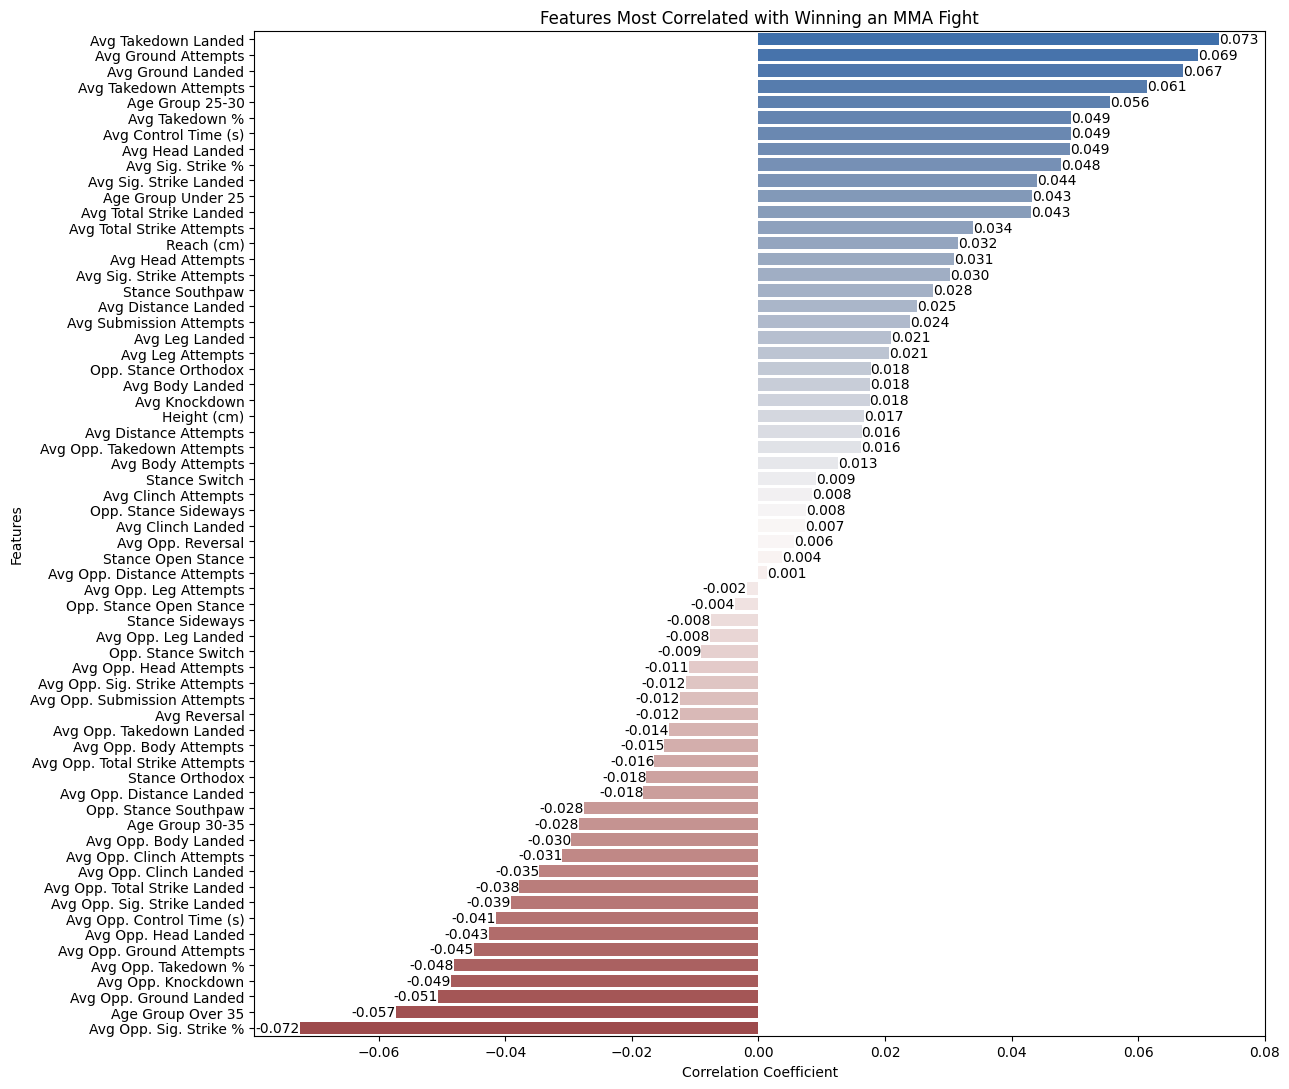

In [32]:
# Calculate correlation with 'Winner'
exclude_columns = ['wins', 'losses', 'draw', 'age_differential', 'age', 'fighter', 'date', 'win_by_TKO_Doctor_Stoppage', 'win_by_Submission', 'win_by_KO/TKO', 'win_by_Decision_Unanimous', 'win_by_Decision_Split', 'win_by_Decision_Majority', 'Weight_lbs', 'longest_win_streak', 'total_title_bouts', 'total_rounds_fought', 'total_time_fought(seconds)', 'current_win_streak', 'current_lose_streak']  # Replace with actual column names
df_filtered = df_fighters.drop(columns=exclude_columns, errors='ignore')  # 'errors="ignore"' avoids errors if the columns are missing

correlation_matrix = df_filtered.corr()

# Extract correlations with 'Winner' column
winner_correlations = correlation_matrix['Winner'].drop('Winner')  # Exclude self-correlation

# Sort by absolute correlation value
sorted_correlations = winner_correlations.sort_values(ascending=False)

sorted_correlations.index = sorted_correlations.index.str.replace('_', ' ').str.title()
sorted_correlations.index = sorted_correlations.index.str.replace('Pct', '%')
sorted_correlations.index = sorted_correlations.index.str.replace('Td', 'Takedown')
sorted_correlations.index = sorted_correlations.index.str.replace('Ctrl', 'Control')
sorted_correlations.index = sorted_correlations.index.str.replace('Opp', 'Opp.')
sorted_correlations.index = sorted_correlations.index.str.replace('Att', 'Attempts')
sorted_correlations.index = sorted_correlations.index.str.replace('(Seconds)', ' (s)')
sorted_correlations.index = sorted_correlations.index.str.replace('Kd', 'Knockdown')
sorted_correlations.index = sorted_correlations.index.str.replace('Rev', 'Reversal')
sorted_correlations.index = sorted_correlations.index.str.replace('Sig', 'Sig.')
sorted_correlations.index = sorted_correlations.index.str.replace('Str', 'Strike')
sorted_correlations.index = sorted_correlations.index.str.replace('Sub', 'Submission')
sorted_correlations.index = sorted_correlations.index.str.replace('Cms', '(cm)')

# Plot the top correlations
plt.figure(figsize=(13, 11))
ax = sns.barplot(
    x=sorted_correlations.values,
    y=sorted_correlations.index,
    palette='vlag',
)

# Add text labels inside the bars
for i in ax.containers:
    ax.bar_label(i, fmt='%.3f')

plt.title('Features Most Correlated with Winning an MMA Fight')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Features')
plt.tight_layout()
plt.show()